In [2]:
import numpy as np
np.random.seed()
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, Callback
from keras.wrappers.scikit_learn import KerasClassifier

# using tensorflow on backend

## Load dataset and check the shape of them

In [3]:
path_train = './train.csv'
path_test = './test.csv'

train_loader = pd.read_csv(path_train, dtype={'target': np.int8, 'id': np.int32})
train = train_loader.drop(['target', 'id'], axis=1)
train_labels = train_loader['target'].values
train_ids = train_loader['id'].values
print('Shape of raw train data:', train.shape)
print('Shape of raw train labels:', train_labels.shape)
print('Shape of raw train ids:', train_ids.shape)
print()

test_loader = pd.read_csv(path_test, dtype={'id': np.int32})
test = test_loader.drop(['id'], axis=1)
test_ids = test_loader['id'].values
print('Shape of raw test data:', test.shape)
print('Shape of raw test ids:', test_ids.shape)

Shape of raw train data: (595212, 57)
Shape of raw train labels: (595212,)
Shape of raw train ids: (595212,)

Shape of raw test data: (892816, 57)
Shape of raw test ids: (892816,)


## Preprocessing

In [4]:
train.columns

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='obj

In [5]:
df = pd.concat((train, test)).reset_index(drop=True)
df[df.isin([-1])].sum().sort_values()

ps_car_03_cat    -1028142.0
ps_car_05_cat     -666910.0
ps_reg_03         -269456.0
ps_car_14         -106425.0
ps_car_07_cat      -28820.0
ps_ind_05_cat      -14519.0
ps_car_09_cat       -1446.0
ps_ind_02_cat        -523.0
ps_car_01_cat        -267.0
ps_ind_04_cat        -228.0
ps_car_02_cat         -10.0
ps_car_11              -6.0
ps_car_12              -1.0
ps_calc_01              0.0
ps_car_15               0.0
ps_car_13               0.0
ps_calc_02              0.0
ps_calc_03              0.0
ps_ind_01               0.0
ps_calc_05              0.0
ps_calc_07              0.0
ps_calc_08              0.0
ps_calc_09              0.0
ps_calc_10              0.0
ps_calc_11              0.0
ps_calc_12              0.0
ps_calc_13              0.0
ps_calc_14              0.0
ps_calc_15_bin          0.0
ps_calc_16_bin          0.0
ps_calc_17_bin          0.0
ps_calc_18_bin          0.0
ps_calc_04              0.0
ps_calc_06              0.0
ps_car_08_cat           0.0
ps_car_10_cat       

In [6]:
del df["ps_car_03_cat"]
del df["ps_car_05_cat"]

for col in df.columns:
    if df[col].isin([-1]).sum() != 0:
        df.loc[df[col] == -1, col] = df.loc[~df[col].isin([-1])][col].describe()['50%']

In [7]:
def scale_data(X, scaler=None):
    if not scaler:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler

In [8]:
# target values
n_train = train.shape[0]
train_test = pd.concat((train, test)).reset_index(drop=True)
col_to_drop = train.columns[train.columns.str.endswith('_cat')]
col_to_label_encoding = train.columns[train.columns.str.endswith('_cat')].astype(str).tolist()

# using label encoding cuz the features count is too large :(
le = LabelEncoder()
for col in col_to_label_encoding:
    train_test[col] = le.fit_transform(train_test[col].astype('category'))

train_test_scaled, scaler = scale_data(train_test)
train = train_test_scaled[:n_train, :]
test = train_test_scaled[n_train:, :]
print('\n Shape of processed train data:', train.shape)
print(' Shape of processed test data:', test.shape)


 Shape of processed train data: (595212, 57)
 Shape of processed test data: (892816, 57)


## Modeling

In [9]:
input_shape = train.shape[1]
input_shape

57

In [10]:
model = Sequential()

model.add(
            Dense(
                200,
                input_dim=input_shape,
                kernel_initializer='glorot_normal',
                ))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100, kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(50, kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Dense(25, kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer="adam", 
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               11600     
                                                                 
 activation (Activation)     (None, 200)               0         
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 activation_1 (Activation)   (None, 100)               0         
                                                        

In [11]:
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train, train_labels, epochs=100, validation_split=0.2, 
                    callbacks=[early_stop, PrintDot()], verbose=0)
history


..........................

In [12]:
df_hist = pd.DataFrame(history.history)
df_hist.tail()

,loss,accuracy,val_loss,val_accuracy
21,0.152609,0.963582,0.168070,0.962392
22,0.152671,0.963582,0.167593,0.962812
23,0.152586,0.963582,0.189985,0.962031
24,0.152530,0.963582,0.183917,0.963055
25,0.152600,0.963582,0.209719,0.961930


<AxesSubplot:>

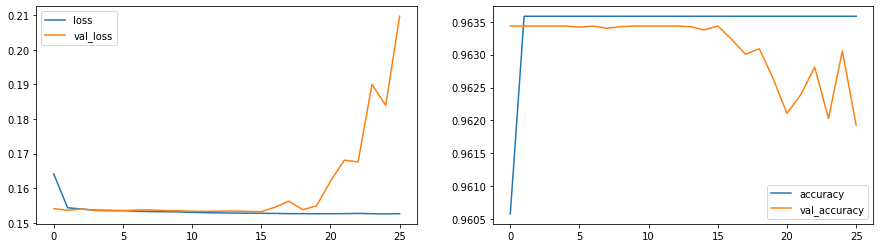

In [13]:
import warnings
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
df_hist[["loss", "val_loss"]].plot(ax=axes[0])
df_hist[["accuracy", "val_accuracy"]].plot(ax=axes[1])

In [14]:
y_pred = model.predict(test).flatten()
print(y_pred.shape)

unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

(892816,)


{0.0048719943: 1,
 0.0055989623: 1,
 0.0057656765: 1,
 0.00577873: 1,
 0.005872041: 1,
 0.0062045157: 1,
 0.0064685643: 1,
 0.0064751506: 1,
 0.00649637: 1,
 0.006496787: 1,
 0.006522268: 1,
 0.0065281093: 1,
 0.0065740943: 1,
 0.0067147613: 1,
 0.0068558753: 1,
 0.006919533: 1,
 0.0069362223: 1,
 0.006951332: 1,
 0.006979674: 1,
 0.0070635676: 1,
 0.0070649683: 1,
 0.0071000457: 1,
 0.007194668: 1,
 0.007201135: 1,
 0.007203251: 1,
 0.0072079003: 1,
 0.0072568953: 1,
 0.0072616637: 1,
 0.007262826: 1,
 0.0072637796: 1,
 0.007268429: 1,
 0.007291764: 1,
 0.0073139668: 1,
 0.007317096: 1,
 0.007329762: 1,
 0.007352054: 1,
 0.007381618: 1,
 0.007389784: 1,
 0.00743559: 1,
 0.0074798167: 1,
 0.0074810684: 1,
 0.0074902475: 1,
 0.0074997246: 1,
 0.007514924: 1,
 0.0075491965: 1,
 0.0075562894: 1,
 0.007590711: 1,
 0.007594466: 1,
 0.0076200664: 1,
 0.007634163: 1,
 0.007668406: 1,
 0.007668853: 1,
 0.0076773763: 1,
 0.0076940656: 1,
 0.0076940954: 1,
 0.007694453: 1,
 0.007698536: 1,
 0.00

In [15]:
pd.DataFrame(y_pred)[0].describe()

count    892816.000000
mean          0.037943
std           0.041994
min           0.004872
25%           0.024523
50%           0.033147
75%           0.044703
max           1.000000
Name: 0, dtype: float64

In [16]:
# y_predict = (y_pred > 0.034527).astype(int)
# y_predict

## Submission

In [17]:
sub = pd.read_csv('sample_submission.csv')
sub['target'] = y_pred
sub.to_csv('my_submission.csv', index=False)